''' The built-in defender’s only available action
is to randomly choose a node to reimage, and the success of this
action is determined by a configured probability.

The defender
is also constrained to ensure a certain level of network
availability at all times. Thus the defender cannot lock out the attacker by reimaging all nodes at once. The defender is not an
agent, but is built directly into the CyberBattleSim environment.

When training starts, the attacker agent, and optionally,
the (random) defender will begin taking steps and acting on the
network. In each step, the attacker chooses an action, then has
the CyberBattleSim environment execute this action. Within this
same step, the defender will have an opportunity to take its own
action as well. The episode will terminate after a number of
steps, and the cumulative reward attained by a trained attacker
is used to compare various training approaches. As described in
the CyberBattleSim documentation, for episode lengths of 1,500
steps, cumulative rewards range from around 270 for a trained
Q agent to up to 430 for a trained Deep Q agent.

To create the multi-agent environment in CyberBattleSim,
the defender agent support must follow the RL model which
includes first the action and observation spaces for the agent.
CyberBattleSim however has a complicated structure in
providing its action space and cannot handle invalid actions. The
agent in training must not issue any invalid action or the
CyberBattleSim environment will crash. As most of the actions
in the action space can be invalid, this limitation forces the agent
in training to be “action syntax aware” so that it launches only
valid actions to the environment. Consequently, CyberBattleSim
prevents the agent training from using directly many of the stateof-the-art RL/DRL algorithm libraries which are action space
agnostic. In addition, the structure of the observation space in
CyberBattleSim also is found to have certain compatibility
issues when tested using selected RL/DRL libraries, e.g., the
stable-baselines3 [12] library.
To fix the interface issues, we implemented first a new class
called AttackerWrapper on top of CyberBattleSim to
handle invalid actions so that the agent is freed from being action
syntax aware. This feature also brings extendibility to
CyberBattleSim in facilitating new additional actions in the
future. The wrapper conforms to the open AI Gym interface to
correct also the observation space incompatibility issues.
Additionally, the wrapper can apply an invalid action penalty to
the reward function to discourage agents from selecting invalid
actions.


Multi-Agent Learning Algorithms

In order to train both attacker and defender agents at the
same time, we started from the stable-baseline3 ‘learn’
algorithm and modified it so it works with two agents at once by
allowing them to take turns performing actions and receiving
rewards. Both attacker and defender agents will indirectly
operate on the same CyberBattleSim environment through their
respective wrappers. In the current experiment, the stablebaseline3 library is used for all agent training algorithms.
A consequence of training on two wrappers at the same time
is that when an episode ends, and reset is called, it needs to be
coordinated with the other wrapper. Whichever wrapper
receives a reset call first should forward that call to the
underlying CyberBattleSim environment and additionally notify
the other wrapper that a reset has occurred. The other wrapper
must not reset the CyberBattleSim environment since it has
already been reset, yet must appear to reset to the baseline agent
it is paired with so that both agents are aware a new episode is
starting, which is important during training.
'''

https://arxiv.org/pdf/2304.11052.pdf

## Integration with CyberBattleSim:

The implementation includes a DefenderWrapper class that interfaces with the CyberBattleSim environment. This wrapper handles action validation and reward calculation, leveraging the existing CyberBattleSim environment without modifying its core code.
Multi-Agent Learning Algorithms:

The paper modifies the stable-baseline3 'learn' algorithm to train both attacker and defender agents simultaneously. This allows the agents to take turns performing actions and receiving rewards in the shared environment.
Coordination between the wrappers is necessary when an episode ends and the environment is reset. This ensures that both agents start a new episode simultaneously, maintaining the integrity of the training process.

## Defender Agent Training Challenges:

A notable challenge in training the defender agent is the dependency of the defender's reward on the attacker's actions. If the attacker performs poorly, the defender might receive misleadingly high rewards without effectively countering sophisticated attacks.
The implementation must ensure that the defender agent is not just action syntax aware but also strategically effective in mitigating a variety of attack strategies.

In [ ]:
import sys
import logging
from typing import cast
import gym
import numpy as np
import matplotlib.pyplot as plt  # type:ignore
from cyberbattle.agents.baseline.learner import TrainedLearner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import numpy

import cyberbattle.agents.baseline.agent_tabularqlearning as a
from cyberbattle.agents.baseline.agent_wrapper import Verbosity
import cyberbattle.agents.baseline.learner as learner
import importlib
import cyberbattle.agents.baseline.agent_dql as dqla
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_ppo as ppo
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint, DefenderGoal
from typing import cast
from cyberbattle._env.cyberbattle_env import CyberBattleEnv
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
from stable_baselines3.a2c.a2c import A2C
from stable_baselines3.ppo.ppo import PPO
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
import os
from stable_baselines3 import PPO
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
import cyberbattle.agents.baseline.agent_ddql as ddqla
import cyberbattle.agents.baseline.agent_dueling_dql as duelingdqla
import cyberbattle.agents.baseline.agent_dueling_ddql as dueling_ddqla
import random
random.seed(120394016)
%matplotlib inline
logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

"""CyberBattle environment based on a simple chain network structure"""

from ..samples.chainpattern import chainpattern
from . import cyberbattle_env
from cyberbattle.simulation.model import PortName, PrivilegeLevel, NodeInfo, NodeID,Environment
from ..simulation import commandcontrol, model, actions

class CyberBattleChain(Environment, cyberbattle_env.CyberBattleEnv):
    """CyberBattle environment based on a simple chain network structure"""

    def __init__(self, size, **kwargs):
        self.size = size
        self.__environment = chainpattern.new_environment(size)  # Initialize __environment
        super().__init__(
            initial_environment=self.__environment,
            **kwargs)

    @ property
    def name(self) -> str:
        return f"CyberBattleChain-{self.size}"


    # Other class methods and attributes...


In [ ]:
import numpy as np
from gym import spaces
from cyberbattle.simulation.model import Environment, NodeInfo, FirewallRule, RulePermission, ListeningService
from cyberbattle.simulation.actions import DefenderAgentActions
from typing import Any, Dict

In [ ]:
import gym
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint, DefenderGoal
import cyberbattle.agents.baseline.agent_wrapper as w
import sys
import logging
import gym
from gym import spaces
import numpy as np
import networkx as nx
import cyberbattle.simulation.actions as actions
import cyberbattle._env.cyberbattle_env as cyberbattle_env
import cyberbattle.agents.random_agent as random_agent
import cyberbattle.samples.chainpattern.chainpattern as chainpattern
import importlib
importlib.reload(actions)
importlib.reload(cyberbattle_env)
importlib.reload(chainpattern)

<module 'cyberbattle.samples.chainpattern.chainpattern' from '/home/gmod1/CyberBattleSim/cyberbattle/samples/chainpattern/chainpattern.py'>

# Initialisation and Configuration of the CyberBattleChain Environment

In [ ]:
gymid = "CyberBattleChain-v0"
env_size = 12
maximum_node_count = 22
maximum_total_credentials = 22

gym_env = gym.make(gymid, size=env_size,attacker_goal=AttackerGoal(
                                         own_atleast=0,
                                         own_atleast_percent=1.0
                                     ),
                   defender_constraint=DefenderConstraint(maintain_sla=0.80),
                   defender_agent=ScanAndReimageCompromisedMachines(probability=0.6, scan_capacity=2, scan_frequency=5),
                   defender_goal=DefenderGoal(eviction=True))

# Define Environment Bounds
ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)




Generated nodes:
[('start', {'data': NodeInfo(services=[], vulnerabilities={'ScanExplorerRecentFiles': VulnerabilityInfo(description='Scan Windows Explorer recent files for possible references to other machines', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedCredentials object at 0x7ff89c0cadf0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7ff852f956a0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=1.0, reward_string='Found a reference to a remote Linux node in bash history')}, value=0, properties=[], firewall=FirewallConfiguration(outgoing=[FirewallRule(port='RDP', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='SSH', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='HTTPS', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='HTTP', permission=<RulePermission.ALLOW: 0>, reason='')], incoming=[FirewallRule(port='RDP', permis

In [ ]:
gym_env.environment
gym_env.environment.network.nodes

NodeView(('start', '13_LinuxNode', '1_LinuxNode', '2_WindowsNode', '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode', '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode', '11_LinuxNode', '12_WindowsNode'))

changed in the defenderAgentActions class


In [ ]:
gym_env.network

# DefenderWrapper

Handle the custom action and observation spaces for the defender and manage action validation

In [ ]:
from gym import spaces
import numpy as np

class DefenderWrapper:
    def __init__(self, environment, name):
        self.env = environment
        self.network = environment.network
        self.defender_actions = DefenderAgentActions(environment)
        self.id_mapping = self.create_id_mapping()  #mapping of numerical IDs to string IDs
        self.action_space = self.define_action_space()
        self.observation_space = self.define_observation_space()
        self.last_attacker_reward = 0
        self.name = name

    def create_id_mapping(self):
        #creates a mapping from numerical IDs to string IDs
        mapping = {}
        for i, node in enumerate(self.env.network.nodes):
            mapping[i] = node
        return mapping

    def render(self):
        print("Rendering the current state of the environment")

    def close(self):
        pass

    '''
    Defender's Action Space
    '''

    def define_action_space(self):
        return spaces.Dict({
            'action_type': spaces.Discrete(5),  #5 different actions
            'node_id': spaces.Discrete(len(self.id_mapping)),  #based on the number of nodes
            'parameter': spaces.Discrete(10)  
        })

    '''
    Observation Space for the Defender
    '''

    def define_observation_space(self):
        #define the observation space for the defender
        return spaces.Dict({
            'infected_nodes': spaces.Box(low=0, high=1, shape=(len(self.id_mapping),), dtype=np.int32),
            'firewall_status': spaces.Box(low=0, high=1, shape=(len(self.id_mapping),), dtype=np.int32),
            'service_status': spaces.Box(low=0, high=1, shape=(len(self.id_mapping),), dtype=np.int32)
        })

    def reimage_node(self, node_id, environment):
        #mark the node for re-imaging and make it unavailable until re-imaging completes
        self.node_reimaging_progress[node_id] = self.REIMAGING_DURATION
        node_info = environment.get_node(node_id)

    def get_node(self, node_id):
        #implement this method to access node information from the environment
        return self.env.get_node(node_id)

    def validate_action(self, action):
        #validate the action taken by the defender
        action_type, numerical_node_id, parameter = action['action_type'], action['node_id'], action['parameter']
        node_id = self.id_mapping.get(numerical_node_id)
        if node_id is None:
            return False  # Invalid node ID

        node_info = self.env.network.nodes[node_id]['data']
        if action_type == 0 and not node_info.reimagable:
            return False  # Node is not re-imageable

        return True  # Action is valid

    def step(self, action):
      reward = 0
      done = False
      info = {}

      if self.validate_action(action):
          action_type, numerical_node_id = action['action_type'], action['node_id']
          node_id = self.id_mapping[numerical_node_id]
          parameter = action['parameter']
          action_result = self.perform_action(action_type, node_id, parameter)
          if action_result is None:
              print(f"Error: Action result is None for action {action_type} on node {node_id}")
              observation = self.get_observation()
              observation['action_mask'] = self.compute_defender_action_mask()
              return observation, -10, done, {'error':'Invalid action result'}
          info['action_result'] = action_result

          reward = self.calculate_reward(action_result)

      else:
          reward = -10
          info['action_result'] = {'status': 'invalid', 'reason': 'Invalid action parameters'}

      observation = self.get_observation()
      observation['action_mask'] = self.compute_defender_action_mask()
      return observation, reward, done, info

    def perform_action(self, action_type, node_id, parameter):
      if action_type == 0:  #Reimage Node
          return self.defender_actions.reimage_node(node_id, self.env)
      elif action_type == 1:  #Block Traffic
          return self.defender_actions.block_traffic(node_id, parameter, incoming=True)
      elif action_type == 2:  #Allow Traffic
          return self.defender_actions.allow_traffic(node_id, parameter, incoming=True)
      elif action_type == 3:  #Stop Service
          return self.defender_actions.stop_service(node_id, parameter)
      elif action_type == 4:  #Start Service
          return self.defender_actions.start_service(node_id, parameter)
      else:
          return {'status': 'error', 'reason': 'Unknown action type'}

    def calculate_reward(self, action_result):
      if action_result['status'] == 'success':
          if action_result.get('type') == 'reimage':
              return 50  #higher reward for re-imaging a compromised node
          else:
              return 25  #standard reward for other successful actions
      elif action_result['status'] == 'failed':
          return -15  #penalty for failed actions
      elif action_result['status'] == 'unnecessary':
          return -5  #smaller penalty for unnecessary actions
      return 0  #default reward for other cases

    def get_observation(self):
        #generate the defender's observation
        observation = {
        'infected_nodes': np.random.randint(0, 2, size=len(self.id_mapping)),
        'firewall_status': np.random.randint(0, 2, size=len(self.id_mapping)),
        'service_status': np.random.randint(0, 2, size=len(self.id_mapping))
        }
        return observation

    def update_last_attacker_reward(self, reward):
        #update the last reward obtained by the attacker
        self.last_attacker_reward = reward


    def default_or_preventive_action(self):
        random_node_id = random.choice(list(self.id_mapping.keys()))
        return self.create_action('Check Firewall', random_node_id)


    def reset(self):
        initial_observation = self.env.reset()
        return initial_observation

    def choose_action(self, state):
        """
        Choose an action based on the current state of the environment.
        """
        print("Choosing action based on the current state")

        #detect infected nodes
        infected_nodes = self.find_infected_nodes()
        print(f"Infected nodes: {infected_nodes}")

        #if there are infected nodes, reimage the first one
        if infected_nodes:
            #node_id_to_reimage = infected_nodes[0]
            node_id_to_reimage = random.choice(infected_nodes)
            print(f"Reimaging node: {node_id_to_reimage}")
            return self.create_action('Reimage Node', node_id_to_reimage)

        #list of preventive actions
        preventive_actions = ['Check Firewall', 'Block Traffic', 'Allow Traffic', 'Stop Service', 'Start Service']
        print("No infected nodes found, selecting a preventive action")

        #randomly select a preventive action
        selected_preventive_action = random.choice(preventive_actions)
        print(f"Selected preventive action: {selected_preventive_action}")

        #randomly select a node for the preventive action
        node_id_for_preventive_action = self.select_node_for_preventive_action()
        print(f"Node selected for preventive action: {node_id_for_preventive_action}")

        return self.create_action(selected_preventive_action, node_id_for_preventive_action)

    def find_infected_nodes(self):
        """
        Find and return a list of numerical IDs of infected (or compromised) nodes.
        """
        infected_nodes = []
        for numerical_id, node_id in self.id_mapping.items():
            node_info = self.env.network.nodes[node_id]['data']
            if node_info.agent_installed or self.has_vulnerabilities(node_id):
                infected_nodes.append(numerical_id)
        return infected_nodes

    def has_vulnerabilities(self, node_id):
        """
        Check if a node has vulnerabilities.
        """
        node_info = self.env.network.nodes[node_id]['data']
        return bool(node_info.vulnerabilities)

    def select_node_for_preventive_action(self):
        """
        Select a node for a preventive action
        """
        return random.choice(list(self.id_mapping.keys()))

    def create_action(self, action_type, node_id):
        """
        Create an action dictionary based on the action type and node ID.
        """
        action_type_mapping = {
            'Reimage Node': 0,
            'Block Traffic': 1,
            'Allow Traffic': 2,
            'Stop Service': 3,
            'Start Service': 4
        }
        if action_type in action_type_mapping:
            action_number = action_type_mapping[action_type]
        else:
            action_number = random.choice(list(action_type_mapping.values()))
        return {'action_type': action_number, 'node_id': node_id, 'parameter': 0}

    def compute_defender_action_mask(self):
        #initialise a blank action mask
        action_mask = {
            'Reimage Node': numpy.zeros(len(self.id_mapping), dtype=numpy.int32),
            'Block Traffic': numpy.zeros(len(self.id_mapping), dtype=numpy.int32),
            'Allow Traffic': numpy.zeros(len(self.id_mapping), dtype=numpy.int32),
            'Stop Service': numpy.zeros(len(self.id_mapping), dtype=numpy.int32),
            'Start Service': numpy.zeros(len(self.id_mapping), dtype=numpy.int32)
        }

        #update the action mask based on the current state of the environment
        for numerical_id, node_id in self.id_mapping.items():
            node_info = self.env.network.nodes[node_id]['data']

            #if node is infected or has vulnerabilities, defender can reimage node
            if node_info.agent_installed or self.has_vulnerabilities(node_id):
                action_mask['Reimage Node'][numerical_id] = 1

            #defender can block traffic and allow traffic on any node
            action_mask['Block Traffic'][numerical_id] = 1
            action_mask['Allow Traffic'][numerical_id] = 1

            #if a service is running on the node, defender can stop service
            if any(service.running for service in node_info.services):
                action_mask['Stop Service'][numerical_id] = 1

            #if a service is stopped on the node, defender can start service
            if any(not service.running for service in node_info.services):
                action_mask['Start Service'][numerical_id] = 1

        return action_mask

    def defender_goal_reached(self):
        for _, node_id in self.id_mapping.items():
            node_info = self.env.network.nodes[node_id]['data']
            if node_info.agent_installed:  
                return False
        return True

    def sample_valid_action(self):
        """
        Randomly selects a valid action for the defender.
        """
        #randomly select an action type
        action_type = random.randint(0, 4) 
        #randomly select a node ID
        node_id = random.choice(list(self.id_mapping.keys()))
        #create a random parameter if needed
        parameter = random.randint(0, 9)
        #construct the action
        action = {
            'action_type': action_type,
            'node_id': node_id,
            'parameter': parameter
        }

        #ensure the action is valid, otherwise re-sample
        while not self.validate_action(action):
            action['action_type'] = random.randint(0, 4)
            action['node_id'] = random.choice(list(self.id_mapping.keys()))
            action['parameter'] = random.randint(0, 9)

        return action

# Instantiate the DefenderWrapper with the CyberBattleChain environment

In [ ]:
#instantiate the DefenderWrapper with the CyberBattleChain environment
defender_name = "MyDefenderEnv"
defender = DefenderWrapper(gym_env,defender_name )

## Check Nodes

In [ ]:
defender.network.nodes

NodeView(('start', '13_LinuxNode', '1_LinuxNode', '2_WindowsNode', '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode', '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode', '11_LinuxNode', '12_WindowsNode'))

In [ ]:
observation = defender.reset()
gym_env.name
gym_env.identifiers
gym_env.bounds

EnvironmentBounds(maximum_total_credentials=1000, maximum_node_count=100, maximum_discoverable_credentials_per_action=5, port_count=8, property_count=14, local_attacks_count=5, remote_attacks_count=2)

# DefenderAgentActions    
### edited class from file

In [ ]:
from typing import Dict
import datetime
from cyberbattle.simulation import model
from cyberbattle.simulation.model import PrivilegeLevel, MachineStatus
from cyberbattle.simulation.model import Identifiers, NodeID, NodeInfo, Environment
from cyberbattle._env.cyberbattle_chain import CyberBattleChain

class DefenderAgentActions:
    """Actions reserved for defender agents"""

    #number of steps it takes to completely reimage a node
    REIMAGING_DURATION = 15

    def __init__(self, environment: CyberBattleChain):
        #map nodes being reimaged to the remaining number of steps to completion
        self.node_reimaging_progress: Dict[model.NodeID, int] = dict()
        #last calculated availability of the network
        self.__network_availability: float = 1.0
        self._environment = environment

    @property
    def network_availability(self):
        return self.__network_availability

    def print_initial_node_states(self):
        print("Initial node states:")
        for node_id in self._environment.network.nodes:
            node_data = self._environment.get_node(node_id)
            print(f"Node {node_id}: {node_data}")

    def reimage_node(self, node_id: model.NodeID, environment: model.Environment):
        """Re-image a computer node"""
        node_info = environment.get_node(node_id)
        action_result = {}
        if node_info.agent_installed:
            node_info.agent_installed = False
            node_info.privilege_level = PrivilegeLevel.NoAccess
            node_info.status = MachineStatus.Imaging
            node_info.last_reimaging = datetime.datetime.now()
            action_result = {"action": "reimage_node", "status": "success", "node_id": node_id}
        elif node_info.status == MachineStatus.Imaging:
            action_result = {"action": "reimage_node", "status": "unnecessary", "node_id": node_id}
        else:
            action_result = {"action": "reimage_node", "status": "failed", "node_id": node_id, "reason": "Node not reimageable or not compromised"}
        return action_result


    def on_attacker_step_taken(self):
        """Function to be called each time a step is taken in the simulation"""
        for node_id in list(self.node_reimaging_progress.keys()):
            remaining_steps = self.node_reimaging_progress[node_id]
            if remaining_steps > 0:
                self.node_reimaging_progress[node_id] -= 1
            else:
                print(f"Machine re-imaging completed: {node_id}")
                node_data = self._environment.get_node(node_id)
                node_data.status = MachineStatus.Running
                self.node_reimaging_progress.pop(node_id)
        #calculate the network availability metric based on machines and services that are running
        total_node_weights = 0
        network_node_availability = 0
        for node_id, node_info in self._environment._cyberbattle_env.__environment.nodes():
            total_service_weights = 0
            running_service_weights = 0
            if isinstance(node_info, ChainNodeInfo):
                for service in node_info.services:
                    total_service_weights += service.sla_weight
                    running_service_weights += service.sla_weight * int(service.running)

                if node_info.status == MachineStatus.Running:
                    adjusted_node_availability = (1 + running_service_weights) / (
                        1 + total_service_weights
                    )
                else:
                    adjusted_node_availability = 0.0

                total_node_weights += node_info.sla_weight
                network_node_availability += (
                    adjusted_node_availability * node_info.sla_weight
                )

        self.__network_availability = network_node_availability / total_node_weights
        assert self.__network_availability <= 1.0 and self.__network_availability >= 0.0

    def override_firewall_rule(
            self,
            node_id: model.NodeID,
            port_name: model.PortName,
            incoming: bool,
            permission: model.RulePermission,
        ):
            node_data = self._environment.get_node(node_id)

            def add_or_patch_rule(rules) -> List[FirewallRule]:
                new_rules = []
                has_matching_rule = False
                for r in rules:
                    if r.port == port_name:
                        has_matching_rule = True
                        new_rules.append(FirewallRule(r.port, permission))
                    else:
                        new_rules.append(r)

                if not has_matching_rule:
                    new_rules.append(model.FirewallRule(port_name, permission))
                return new_rules

            if incoming:
                node_data.firewall.incoming = add_or_patch_rule(node_data.firewall.incoming)
            else:
                node_data.firewall.outgoing = add_or_patch_rule(node_data.firewall.outgoing)


    #blocks network traffic on specific port of node, if node is running, the traffic on the node can be blocked
    #failure is is machine not running
    def block_traffic(self, node_id: model.NodeID, port_name: model.PortName, incoming: bool):
        node_data = self._environment.get_node(node_id)
        if node_data.status == MachineStatus.Running:
            self.override_firewall_rule(node_id, port_name, incoming, model.RulePermission.BLOCK)
            action_result = {"action": "block_traffic", "status": "success", "node_id": node_id, "port_name": port_name}
        else:
            action_result = {"action": "block_traffic", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Machine not running"}
        return action_result

    #allows network traffic on specific port of node, if node is running, the traffic on the node is allowed
    #failure is is machine not running
    def allow_traffic(self, node_id: model.NodeID, port_name: model.PortName, incoming: bool):
        node_data = self._environment.get_node(node_id)
        if node_data.status == MachineStatus.Running:
            self.override_firewall_rule(node_id, port_name, incoming, model.RulePermission.ALLOW)
            action_result = {"action": "allow_traffic", "status": "success", "node_id": node_id, "port_name": port_name}
        else:
            action_result = {"action": "allow_traffic", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Machine not running"}
        return action_result

    #stops service on specific node, if node is running and the specified service is running, it can be stopped successfully
    #failure is is if machine is not running and service is not found
    def stop_service(self, node_id: model.NodeID, port_name: model.PortName):
      """ Stop a service on a given node """
      node_data = self._environment.get_node(node_id)
      action_result = {}
      if node_data.status == MachineStatus.Running:
          service_found = False
          for service in node_data.services:
              if service.name == port_name:
                  if service.running:
                      service.running = False
                      service_found = True
                      action_result = {"action": "stop_service", "status": "success", "node_id": node_id, "port_name": port_name}
                      break
                  else:
                      action_result = {"action": "stop_service", "status": "unnecessary", "node_id": node_id, "port_name": port_name, "reason": "Service already stopped"}
                      break
          if not service_found:
              action_result = {"action": "stop_service", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Service not found"}
      else:
          action_result = {"action": "stop_service", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Machine not running"}
      return action_result

    #starts service on specific node
    #success if specified service is not running and can be started
    #unneccesary = service already running
    #failure = machine not running and srvice not running
    def start_service(self, node_id: model.NodeID, port_name: model.PortName):
        """ Start a service on a given node """
        node_data = self._environment.get_node(node_id)
        action_result = {}
        if node_data.status == MachineStatus.Running:
            service_found = False
            for service in node_data.services:
                if service.name == port_name:
                    if not service.running:
                        service.running = True
                        service_found = True
                        action_result = {"action": "start_service", "status": "success", "node_id": node_id, "port_name": port_name}
                        break
                    else:
                        action_result = {"action": "start_service", "status": "unnecessary", "node_id": node_id, "port_name": port_name, "reason": "Service already running"}
                        break
            if not service_found:
                action_result = {"action": "start_service", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Service not found"}
        else:
            action_result = {"action": "start_service", "status": "failed", "node_id": node_id, "port_name": port_name, "reason": "Machine not running"}
        return action_result

In [ ]:
gym_env.action_space

DiscriminatedUnion(connect:MultiDiscrete([ 100  100    8 1000]), local_vulnerability:MultiDiscrete([100   5]), remote_vulnerability:MultiDiscrete([100 100   2]))

# Initial node states

In [ ]:
random.seed(120394016)
defender_actions = DefenderAgentActions(defender)
defender_actions.print_initial_node_states()

Initial node states:
Node start: NodeInfo(services=[], vulnerabilities={'ScanExplorerRecentFiles': VulnerabilityInfo(description='Scan Windows Explorer recent files for possible references to other machines', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedCredentials object at 0x7ff89c0cadf0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7ff852f956a0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=1.0, reward_string='Found a reference to a remote Linux node in bash history')}, value=0, properties=[], firewall=FirewallConfiguration(outgoing=[FirewallRule(port='RDP', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='SSH', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='HTTPS', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='HTTP', permission=<RulePermission.ALLOW: 0>, reason='')], incoming=[FirewallRule(port='RDP', permission

Connect Action:

This action seems to have four parameters, each with a range of possible values (100, 100, 8, 1000).
A possible action might look like: {'connect': [node_id, target_node_id, port_index, credential_index]}.
Local Vulnerability Action:

This action has two parameters, with ranges of values (100, 5).
A possible action might look like: {'local_vulnerability': [node_id, vulnerability_index]}.
Remote Vulnerability Action:

This action has three parameters, with ranges of values (100, 100, 2).
A possible action might look like: {'remote_vulnerability': [source_node_id, target_node_id, vulnerability_index]}.

# Fixed Attacker Not working

In [ ]:
class FixedAttacker:
    def __init__(self):
        # Define a fixed sequence of actions targeting the provided nodes.
        self.nodes = [
            'start', '13_LinuxNode', '1_LinuxNode', '2_WindowsNode',
            '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode',
            '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode',
            '11_LinuxNode', '12_WindowsNode'
        ]
        self.actions = self.generate_fixed_actions()
        self.current_action_index = 0

    def generate_fixed_actions(self):
        actions = []

        # Example: exploit a remote vulnerability from each node to the next
        for i in range(len(self.nodes) - 1):
            source_node = self.nodes[i]
            target_node = self.nodes[i + 1]
            # Example vulnerability ID
            vuln_id = 'vuln1'

            action = {
                'exploit_remote_vulnerability': {
                    'node_id': source_node,
                    'target_node_id': target_node,
                    'vulnerability_id': vuln_id
                }
            }
            actions.append(action)

        return actions

    def next_action(self):
        action = self.actions[self.current_action_index]
        self.current_action_index = (self.current_action_index + 1) % len(self.actions)
        return action

    def reset(self):
        self.current_action_index = 0


## Defender Agent Simulation in Network Defense Environment Draft 1

In [ ]:
import logging

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Setup parameters
total_episodes = 1
max_steps_per_episode = 1000

The agent seems to be focusing on the 'Reimage Node' action, which is appropriate given the presence of numerous infected nodes.

In [ ]:
from cyberbattle.agents.baseline.learner import Learner
from cyberbattle.agents.baseline.agent_wrapper import AgentWrapper
from typing import Tuple, Optional, TypedDict, List

# EpsilonGreedyLearner

In [ ]:
import numpy as np
from cyberbattle._env.cyberbattle_env import Action

class EpsilonGreedyLearner:
    def __init__(self, env, defender, epsilon=0.1):
        self.env = env
        self.defender = defender
        self.epsilon = epsilon

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.explore()
        else:
            return self.exploit(state)

    def explore(self):
        #randomly select an action from the defender's valid actions
        return self.defender.sample_valid_action()

    def exploit(self, state):
        return self.defender.sample_valid_action()

    def update_state(self, state, reward):
        pass

    def end_of_episode(self, episode_number):
        pass

class TrainedDefender:
    pass


# class DefenderEpsilonGreedyLearner(EpsilonGreedyLearner)

In [ ]:
import numpy as np
from typing import Tuple, Optional
import logging
import abc
from cyberbattle._env import cyberbattle_env

# Initialise logging
logging.basicConfig(level=logging.INFO)


class DefenderEpsilonGreedyLearner(EpsilonGreedyLearner):
    def __init__(self, env, defender, ep, gamma, learning_rate, epsilon, state_space_size, action_space_size):
        super().__init__(env, defender, epsilon)
        self.defender = defender
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.q_matrix = np.zeros((self.state_space_size, self.action_space_size))
        self.gamma = gamma


    def decide_action(self, wrapped_env, observation) -> Tuple[str, cyberbattle_env.Action, object]:
        if np.random.rand() < self.epsilon:
            return self.explore(wrapped_env)
        else:
            return self.exploit(wrapped_env, observation)

    def explore(self, wrapped_env) -> Tuple[str, cyberbattle_env.Action, object]:
        action = wrapped_env.sample_valid_action()
        action_metadata = None
        action_style = 'explore'
        return action_style, action, action_metadata

    def exploit(self, wrapped_env, observation) -> Tuple[str, Optional[cyberbattle_env.Action], object]:
        action = wrapped_env.sample_valid_action()
        action_metadata = None
        action_style = 'exploit'
        return action_style, action, action_metadata

    def on_step(self, wrapped_env, observation, reward, done, info, action_metadata):
        current_state = self.encode_state(observation)
        action = self.encode_action(action_metadata)
        next_state = self.encode_state(observation) if not done else None
        self.update_q_matrix(current_state, action, reward, next_state)

    def update_q_matrix(self, state, action, reward, next_state):
        max_future_q = 0 if next_state is None else np.max(self.q_matrix[next_state])
        current_q = self.q_matrix[state, action]
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.gamma * max_future_q)
        self.q_matrix[state, action] = new_q

    def parameters_as_string(self):
        return "Defender learner parameters: "

    def encode_state(self, observation):
        state_index = 0
        return state_index

    def encode_action(self, action_metadata):
        action_index = 0
        return action_index

    def new_episode(self):
        pass

    def end_of_episode(self, i_episode, t):
        pass

    def end_of_iteration(self, t, done):
        pass

    def all_parameters_as_string(self):
        return ''

    def loss_as_string(self):
        return ''

    def stateaction_as_string(self, action_metadata):
        return ''


In [ ]:
Breakdown = TypedDict('Breakdown', {
    'local': int,
    'remote': int,
    'connect': int
})

Outcomes = TypedDict('Outcomes', {
    'reward': Breakdown,
    'noreward': Breakdown
})

Stats = TypedDict('Stats', {
    'exploit': Outcomes,
    'explore': Outcomes,
    'exploit_deflected_to_explore': int
})

TrainedLearner = TypedDict('TrainedLearner', {
    'all_episodes_rewards': List[List[float]],
    'all_episodes_availability': List[List[float]],
    'learner': Learner,
    'trained_on': str,
    'title': str
})

# Parameters:
* cyberbattle_gym_env: The CyberBattle gym environment on which the training occurs.
environment_properties: Bounds and properties of the environment.
* learner: The learning algorithm, a custom defender class that uses epsilon-greedy strategy.
* episode_count: The number of training episodes.
* iteration_count: The maximum number of iterations (steps) in each episode.
* epsilon: The exploration-exploitation parameter.
0.0 for pure exploitation (using learned policy only).
1.0 for pure exploration (random actions).
* epsilon_minimum: The minimum value to which epsilon can decay.
* epsilon_multdecay: Multiplier for epsilon decay after each episode (optional).
* epsilon_exponential_decay: Controls the rate of exponential decay of epsilon (optional).
* render: Whether to visually render the environment after each episode.
* render_last_episode_rewards_to: File path to render environment with rewards for the last episode (optional).
* verbosity: Controls the amount of logging.
* plot_episodes_length: Whether to plot the length of episodes upon completion.

# Functionality:
Initialisation: The function initializes various parameters, including epsilon values and plotting tools.


# epsilon_greedy_defender_training function

In [ ]:
def epsilon_greedy_defender_training(
    cyberbattle_gym_env: cyberbattle_env.CyberBattleEnv,
    environment_properties: w.EnvironmentBounds,
    learner: DefenderEpsilonGreedyLearner,
    title: str,
    episode_count: int,
    iteration_count: int,
    epsilon: float,
    epsilon_minimum=0.0,
    epsilon_multdecay: Optional[float] = None,
    epsilon_exponential_decay: Optional[int] = None,
    render=True,
    render_last_episode_rewards_to: Optional[str] = None,
    verbosity: Verbosity = Verbosity.Normal,
    plot_episodes_length=True
) -> TrainedLearner:
    """Epsilon greedy search for CyberBattle gym environments

    Parameters
    ==========

    - cyberbattle_gym_env -- the CyberBattle environment to train on

    - learner --- the policy learner/exploiter

    - episode_count -- Number of training episodes

    - iteration_count -- Maximum number of iterations in each episode

    - epsilon -- explore vs exploit
        - 0.0 to exploit the learnt policy only without exploration
        - 1.0 to explore purely randomly

    - epsilon_minimum -- epsilon decay clipped at this value.
    Setting this value too close to 0 may leed the search to get stuck.

    - epsilon_decay -- epsilon gets multiplied by this value after each episode

    - epsilon_exponential_decay - if set use exponential decay. The bigger the value
    is, the slower it takes to get from the initial `epsilon` to `epsilon_minimum`.

    - verbosity -- verbosity of the `print` logging

    - render -- render the environment interactively after each episode

    - render_last_episode_rewards_to -- render the environment to the specified file path
    with an index appended to it each time there is a positive reward
    for the last episode only

    - plot_episodes_length -- Plot the graph showing total number of steps by episode
    at th end of the search.

    Note on convergence
    ===================

    Setting 'minimum_espilon' to 0 with an exponential decay <1
    makes the learning converge quickly (loss function getting to 0),
    but that's just a forced convergence, however, since when
    epsilon approaches 0, only the q-values that were explored so
    far get updated and so only that subset of cells from
    the Q-matrix converges.

    """

    print(f"###### {title}\n"
          f"Learning with: episode_count={episode_count},"
          f"iteration_count={iteration_count},"
          f"ϵ={epsilon},"
          f'ϵ_min={epsilon_minimum}, '
          + (f"ϵ_multdecay={epsilon_multdecay}," if epsilon_multdecay else '')
          + (f"ϵ_expdecay={epsilon_exponential_decay}," if epsilon_exponential_decay else '') +
          f"{learner.parameters_as_string()}")

    initial_epsilon = epsilon
    successful_reimaging_count = 0
    starting_services_count = 0
    allowing_traffic_count = 0
    blocking_traffic_count = 0
    stopping_services_count = 0
    all_episodes_rewards = []
    all_episodes_availability = []
    defender_name = 'MyDefenderEnv'
    wrapped_env = DefenderWrapper(cyberbattle_gym_env,defender_name)
    steps_done = 0
    plot_title = f"{title} (epochs={episode_count}, ϵ={initial_epsilon}, ϵ_min={epsilon_minimum}," \
        + (f"ϵ_multdecay={epsilon_multdecay}," if epsilon_multdecay else '') \
        + (f"ϵ_expdecay={epsilon_exponential_decay}," if epsilon_exponential_decay else '') \
        + learner.parameters_as_string()
    plottraining = PlotTraining(title=plot_title, render_each_episode=render)

    render_file_index = 1

    for i_episode in range(1, episode_count + 1):

        print(f"  ## Episode: {i_episode}/{episode_count} '{title}' "
              f"ϵ={epsilon:.4f}, "
              f"{learner.parameters_as_string()}")

        observation = wrapped_env.reset()
        total_reward = 0.0
        all_rewards = []
        all_availability = []
        learner.new_episode()

        stats = Stats(exploit=Outcomes(reward=Breakdown(local=0, remote=0, connect=0),
                                       noreward=Breakdown(local=0, remote=0, connect=0)),
                      explore=Outcomes(reward=Breakdown(local=0, remote=0, connect=0),
                                       noreward=Breakdown(local=0, remote=0, connect=0)),
                      exploit_deflected_to_explore=0
                      )

        episode_ended_at = None
        sys.stdout.flush()

        bar = progressbar.ProgressBar(
            widgets=[
                'Episode ',
                f'{i_episode}',
                '|Iteration ',
                progressbar.Counter(),
                '|',
                progressbar.Variable(name='reward', width=6, precision=10),
                '|',
                progressbar.Variable(name='last_reward_at', width=4),
                '|',
                progressbar.Timer(),
                progressbar.Bar()
            ],
            redirect_stdout=False)

        for t in bar(range(1, 1 + iteration_count)):

            if epsilon_exponential_decay:
                epsilon = epsilon_minimum + math.exp(-1. * steps_done /
                                                     epsilon_exponential_decay) * (initial_epsilon - epsilon_minimum)

            steps_done += 1

            x = np.random.rand()
            if x <= epsilon:
                action_style, gym_action, action_metadata = learner.explore(wrapped_env)
            else:
                action_style, gym_action, action_metadata = learner.exploit(wrapped_env, observation)
                if not gym_action:
                    stats['exploit_deflected_to_explore'] += 1
                    _, gym_action, action_metadata = learner.explore(wrapped_env)

            logging.debug(f"gym_action={gym_action}, action_metadata={action_metadata}")
            observation, reward, done, info = wrapped_env.step(gym_action)
            print(f"  Observation:: {observation}")
            print(f"Iteration {t}:")
            print(f"  Action Taken: {gym_action}")
            print(f"  Action Result: {info.get('action_result', 'No additional info')}")
            print(f"  Reward: {reward}")
            print(f"  New Observation: {observation}")

            if gym_action == 'Reimage Node' and info.get('action_result', 'No additional info') > 0:
                successful_reimaging_count += 1
            elif gym_action == 'Start Service':
                starting_services_count += 1
            elif gym_action == 'Allow Traffic':
                allowing_traffic_count += 1
            elif gym_action == 'Block Traffic':
                blocking_traffic_count += 1
            elif gym_action == 'Stop Service':
                stopping_services_count += 1

            action_type = 'exploit' if action_style == 'exploit' else 'explore'
            outcome = 'reward' if reward > 0 else 'noreward'
            if 'local_vulnerability' in gym_action:
                stats[action_type][outcome]['local'] += 1
            elif 'remote_vulnerability' in gym_action:
                stats[action_type][outcome]['remote'] += 1
            else:
                stats[action_type][outcome]['connect'] += 1

            learner.on_step(wrapped_env, observation, reward, done, info, action_metadata)
            assert np.shape(reward) == ()

            all_rewards.append(reward)
            if 'network_availability' in info:
                all_availability.append(info['network_availability'])
            else:
                all_availability.append(0) 
            total_reward += reward
            bar.update(t, reward=total_reward)
            if reward > 0:
                bar.update(t, last_reward_at=t)

            if verbosity == Verbosity.Verbose or (verbosity == Verbosity.Normal and reward > 0):
                sign = ['-', '+'][reward > 0]

                print(f"    {sign} t={t} {action_style} r={reward} cum_reward:{total_reward} "
                      f"a={action_metadata}-{gym_action} "
                      f"creds={len(observation['credential_cache_matrix'])} "
                      f" {learner.stateaction_as_string(action_metadata)}")

            if i_episode == episode_count \
                    and render_last_episode_rewards_to is not None \
                    and reward > 0:
                fig = cyberbattle_gym_env.render_as_fig()
                fig.write_image(f"{render_last_episode_rewards_to}-e{i_episode}-{render_file_index}.png")
                render_file_index += 1

            learner.end_of_iteration(t, done)

            if done:
                episode_ended_at = t
                bar.finish(dirty=True)
                break

        sys.stdout.flush()

        loss_string = learner.loss_as_string()
        if loss_string:
            loss_string = "loss={loss_string}"

        if episode_ended_at:
            print(f"  Episode {i_episode} ended at t={episode_ended_at} {loss_string}")
        else:
            print(f"  Episode {i_episode} stopped at t={iteration_count} {loss_string}")

        print_stats(stats)
        print(f"  Episode {i_episode} breakdown:")
        print(f"    Successful Reimaging Count: {successful_reimaging_count}")
        print(f"    Starting Services Count: {starting_services_count}")
        print(f"    Allowing Traffic Count: {allowing_traffic_count}")
        print(f"    Blocking Traffic Count: {blocking_traffic_count}")
        print(f"    Stopping Services Count: {stopping_services_count}")

        all_episodes_rewards.append(all_rewards)
        all_episodes_availability.append(all_availability)

        length = episode_ended_at if episode_ended_at else iteration_count
        learner.end_of_episode(i_episode=i_episode, t=length)
        if plot_episodes_length:
            plottraining.episode_done(length)
        if render:
            wrapped_env.render()

        if epsilon_multdecay:
            epsilon = max(epsilon_minimum, epsilon * epsilon_multdecay)

    wrapped_env.close()
    print("simulation ended")
    if plot_episodes_length:
        plottraining.plot_end()

    return TrainedLearner(
        all_episodes_rewards=all_episodes_rewards,
        all_episodes_availability=all_episodes_availability,
        learner=learner,
        trained_on=cyberbattle_gym_env.name,
        title=plot_title
    )

In [ ]:
def print_stats(stats):
    """Print learning statistics"""
    def print_breakdown(stats, actiontype: str):
        def ratio(kind: str) -> str:
            x, y = stats[actiontype]['reward'][kind], stats[actiontype]['noreward'][kind]
            sum = x + y
            if sum == 0:
                return 'NaN'
            else:
                return f"{(x / sum):.2f}"

        def print_kind(kind: str):
            print(
                f"    {actiontype}-{kind}: {stats[actiontype]['reward'][kind]}/{stats[actiontype]['noreward'][kind]} "
                f"({ratio(kind)})")
        print_kind('local')
        print_kind('remote')
        print_kind('connect')

    print("  Breakdown [Reward/NoReward (Success rate)]")
    print_breakdown(stats, 'explore')
    print_breakdown(stats, 'exploit')
    print(f"  exploit deflected to exploration: {stats['exploit_deflected_to_explore']}")


In [ ]:
from cyberbattle.agents.baseline.agent_wrapper import ActionTrackingStateAugmentation, StateAugmentation
from cyberbattle.agents.baseline.plotting import PlotTraining, plot_averaged_cummulative_rewards
import progressbar
import math
from cyberbattle.agents.baseline import learner

# State Space and Action Space

In [ ]:
gym_env.action_space
ep

EnvironmentBounds(maximum_total_credentials=22, maximum_node_count=22, maximum_discoverable_credentials_per_action=22, port_count=8, property_count=14, local_attacks_count=5, remote_attacks_count=2)

In [ ]:
state_space_size = w.HashEncoding(ep, [
            # Feature_discovered_node_count(),
            # Feature_discovered_credential_count(),
            w.Feature_discovered_ports_sliding(ep),
            w.Feature_discovered_nodeproperties_sliding(ep),
            w.Feature_discovered_notowned_node_count(ep, 3)
        ], 5000)  # should not be too small, pick something big to avoid collision

action_space_size = w.RavelEncoding(ep, [
            w.Feature_active_node_properties(ep)])

In [ ]:
state_space_size

MultiDiscrete([5000])

In [ ]:
action_space_size

MultiDiscrete([16384])

In [ ]:
epsilon = 0.1  #exploration rate
gamma = 0.9    #discount factor
learning_rate = 0.01  #learning rate
ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)
#sizes of state and action spaces
state_space_size = 5000  #size of the state space
action_space_size = 16384  #size of the action space

#create an instance of DefenderEpsilonGreedyLearner
learner = DefenderEpsilonGreedyLearner(gym_env, defender, ep, gamma, learning_rate, epsilon, state_space_size, action_space_size)

#from cyberbattle.agents.baseline.learner import epsilon_greedy_search

# Using DefenderEpsilonGreedyLearner(EpsilonGreedyLearner)

## * explore chooses actions randomly
## * exploit does the same so need to use qtable or neural network

###### Defender Training
Learning with: episode_count=1,iteration_count=1000,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,Defender learner parameters: [Add your parameters description here]
  ## Episode: 1/1 'Defender Training' ϵ=0.9000, Defender learner parameters: [Add your parameters description here]


Episode 1|Iteration 30|reward:  150.0|last_reward_at:   29|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]), 'service_status': array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 1:
  Action Taken: {'action_type': 0, 'node_id': 5, 'parameter': 2}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '4_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 

Episode 1|Iteration 32|reward:  120.0|last_reward_at:   30|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]), 'service_status': array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 31:
  Action Taken: {'action_type': 4, 'node_id': 1, 'parameter': 4}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 4, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 0, 1,

Episode 1|Iteration 76|reward:  460.0|last_reward_at:   76|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]), 'service_status': array([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 34:
  Action Taken: {'action_type': 0, 'node_id': 3, 'parameter': 5}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '2_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([0,

Episode 1|Iteration 81|reward:  505.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Observation:: {'infected_nodes': array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]), 'service_status': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 78:
  Action Taken: {'action_type': 1, 'node_id': 3, 'parameter': 4}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '2_WindowsNode', 'port_name': 4}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1

Episode 1|Iteration 134|reward:  430.0|last_reward_at:  134|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]), 'firewall_status': array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]), 'service_status': array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 83:
  Action Taken: {'action_type': 3, 'node_id': 4, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '3_LinuxNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]), 'firewall_status': array([1, 1, 0, 1

Episode 1|Iteration 140|reward:  540.0|last_reward_at:  139|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]), 'service_status': array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 136:
  Action Taken: {'action_type': 1, 'node_id': 9, 'parameter': 1}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '8_WindowsNode', 'port_name': 1}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1

Episode 1|Iteration 198|reward:  390.0|last_reward_at:  198|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]), 'service_status': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 141:
  Action Taken: {'action_type': 0, 'node_id': 2, 'parameter': 9}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '1_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 

Episode 1|Iteration 205|reward:  405.0|last_reward_at:  203|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]), 'service_status': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 200:
  Action Taken: {'action_type': 2, 'node_id': 8, 'parameter': 9}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '7_LinuxNode', 'port_name': 9}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 

Episode 1|Iteration 265|reward:  425.0|last_reward_at:  263|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]), 'service_status': array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 206:
  Action Taken: {'action_type': 2, 'node_id': 11, 'parameter': 5}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '10_WindowsNode', 'port_name': 5}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,

Episode 1|Iteration 270|reward:  430.0|last_reward_at:  270|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]), 'service_status': array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 266:
  Action Taken: {'action_type': 3, 'node_id': 11, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '10_WindowsNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 1,

Episode 1|Iteration 324|reward:  780.0|last_reward_at:  323|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]), 'firewall_status': array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]), 'service_status': array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 272:
  Action Taken: {'action_type': 0, 'node_id': 4, 'parameter': 4}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '3_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]), 'firewall_status': array([0, 

Episode 1|Iteration 326|reward:  830.0|last_reward_at:  325|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]), 'service_status': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 325:
  Action Taken: {'action_type': 1, 'node_id': 3, 'parameter': 5}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '2_WindowsNode', 'port_name': 5}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0

Episode 1|Iteration 370|reward: 1010.0|last_reward_at:  368|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]), 'service_status': array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 327:
  Action Taken: {'action_type': 4, 'node_id': 3, 'parameter': 7}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 7, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 

Episode 1|Iteration 377|reward: 1065.0|last_reward_at:  377|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]), 'firewall_status': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]), 'service_status': array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 372:
  Action Taken: {'action_type': 4, 'node_id': 11, 'parameter': 8}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '10_WindowsNode', 'port_name': 8, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]), 'firewall_status': array([1, 1

Episode 1|Iteration 447|reward: 1135.0|last_reward_at:  445|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 378:
  Action Taken: {'action_type': 3, 'node_id': 3, 'parameter': 1}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 1, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 1

Episode 1|Iteration 451|reward: 1155.0|last_reward_at:  451|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]), 'firewall_status': array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]), 'service_status': array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 449:
  Action Taken: {'action_type': 0, 'node_id': 11, 'parameter': 6}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '10_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]), 'firewall_status': array(

Episode 1|Iteration 500|reward: 1420.0|last_reward_at:  499|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0]), 'service_status': array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 453:
  Action Taken: {'action_type': 2, 'node_id': 8, 'parameter': 2}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '7_LinuxNode', 'port_name': 2}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

Episode 1|Iteration 502|reward: 1430.0|last_reward_at:  502|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]), 'service_status': array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 501:
  Action Taken: {'action_type': 3, 'node_id': 1, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 0,

Episode 1|Iteration 539|reward: 1555.0|last_reward_at:  538|Elapsed Time: 0:00:02||


  Observation:: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 504:
  Action Taken: {'action_type': 3, 'node_id': 8, 'parameter': 3}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '7_LinuxNode', 'port_name': 3, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 0, 0,

Episode 1|Iteration 542|reward: 1590.0|last_reward_at:  540|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]), 'service_status': array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 540:
  Action Taken: {'action_type': 2, 'node_id': 4, 'parameter': 4}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '3_LinuxNode', 'port_name': 4}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 

Episode 1|Iteration 574|reward: 1630.0|last_reward_at:  569|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]), 'service_status': array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 543:
  Action Taken: {'action_type': 4, 'node_id': 7, 'parameter': 0}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '6_WindowsNode', 'port_name': 0, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 

Episode 1|Iteration 574|reward: 1630.0|last_reward_at:  574|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]), 'service_status': array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 575:
  Action Taken: {'action_type': 0, 'node_id': 6, 'parameter': 8}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '5_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 

Episode 1|Iteration 605|reward: 1605.0|last_reward_at:  604|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]), 'firewall_status': array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]), 'service_status': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 576:
  Action Taken: {'action_type': 4, 'node_id': 1, 'parameter': 1}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 1, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]), 'firewall_status': array([0, 0, 0

Episode 1|Iteration 606|reward: 1630.0|last_reward_at:  606|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]), 'firewall_status': array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]), 'service_status': array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 607:
  Action Taken: {'action_type': 3, 'node_id': 11, 'parameter': 9}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '10_WindowsNode', 'port_name': 9, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]), 'firewall_status': array([0, 1,

Episode 1|Iteration 638|reward: 1630.0|last_reward_at:  637|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]), 'service_status': array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 608:
  Action Taken: {'action_type': 0, 'node_id': 4, 'parameter': 4}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '3_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 

Episode 1|Iteration 639|reward: 1655.0|last_reward_at:  639|Elapsed Time: 0:00:02||


Iteration 639:
  Action Taken: {'action_type': 1, 'node_id': 13, 'parameter': 1}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '12_WindowsNode', 'port_name': 1}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]), 'service_status': array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1

Episode 1|Iteration 674|reward: 1970.0|last_reward_at:  670|Elapsed Time: 0:00:02||


  Observation:: {'infected_nodes': array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 641:
  Action Taken: {'action_type': 2, 'node_id': 1, 'parameter': 1}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '13_LinuxNode', 'port_name': 1}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0

Episode 1|Iteration 675|reward: 1955.0|last_reward_at:  670|Elapsed Time: 0:00:02||


  Observation:: {'infected_nodes': array([1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]), 'service_status': array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 676:
  Action Taken: {'action_type': 4, 'node_id': 2, 'parameter': 3}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '1_LinuxNode', 'port_name': 3, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 0

Episode 1|Iteration 710|reward: 2110.0|last_reward_at:  710|Elapsed Time: 0:00:03||


  Observation:: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]), 'service_status': array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 677:
  Action Taken: {'action_type': 1, 'node_id': 2, 'parameter': 5}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '1_LinuxNode', 'port_name': 5}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,

Episode 1|Iteration 711|reward: 2135.0|last_reward_at:  711|Elapsed Time: 0:00:03||


  Observation:: {'infected_nodes': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0]), 'service_status': array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 712:
  Action Taken: {'action_type': 1, 'node_id': 7, 'parameter': 8}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '6_WindowsNode', 'port_name': 8}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 

Episode 1|Iteration 750|reward: 2070.0|last_reward_at:  750|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 'firewall_status': array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]), 'service_status': array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 713:
  Action Taken: {'action_type': 4, 'node_id': 13, 'parameter': 3}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '12_WindowsNode', 'port_name': 3, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 'firewall_status': array([1, 1

Episode 1|Iteration 754|reward: 2050.0|last_reward_at:  752|Elapsed Time: 0:00:03||


  Observation:: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]), 'service_status': array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 752:
  Action Taken: {'action_type': 2, 'node_id': 5, 'parameter': 6}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '4_WindowsNode', 'port_name': 6}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 

Episode 1|Iteration 790|reward: 1950.0|last_reward_at:  789|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 755:
  Action Taken: {'action_type': 0, 'node_id': 12, 'parameter': 7}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '11_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]), 'firewall_status': array([1

Episode 1|Iteration 793|reward: 1945.0|last_reward_at:  792|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]), 'service_status': array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 791:
  Action Taken: {'action_type': 4, 'node_id': 10, 'parameter': 1}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '9_LinuxNode', 'port_name': 1, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 1

Episode 1|Iteration 821|reward: 2045.0|last_reward_at:  817|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]), 'service_status': array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 794:
  Action Taken: {'action_type': 1, 'node_id': 11, 'parameter': 4}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '10_WindowsNode', 'port_name': 4}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,

Episode 1|Iteration 823|reward: 2055.0|last_reward_at:  823|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]), 'firewall_status': array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]), 'service_status': array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 822:
  Action Taken: {'action_type': 3, 'node_id': 10, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '9_LinuxNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]), 'firewall_status': array([0, 0, 0,

Episode 1|Iteration 849|reward: 2225.0|last_reward_at:  848|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]), 'service_status': array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 824:
  Action Taken: {'action_type': 1, 'node_id': 2, 'parameter': 2}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '1_LinuxNode', 'port_name': 2}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 

Episode 1|Iteration 850|reward: 2250.0|last_reward_at:  850|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]), 'firewall_status': array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]), 'service_status': array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 851:
  Action Taken: {'action_type': 0, 'node_id': 7, 'parameter': 3}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '6_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]), 'firewall_status': array([1

Episode 1|Iteration 879|reward: 2215.0|last_reward_at:  874|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0]), 'service_status': array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 852:
  Action Taken: {'action_type': 1, 'node_id': 13, 'parameter': 0}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '12_WindowsNode', 'port_name': 0}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,

Episode 1|Iteration 881|reward: 2225.0|last_reward_at:  874|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]), 'firewall_status': array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]), 'service_status': array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 881:
  Action Taken: {'action_type': 2, 'node_id': 13, 'parameter': 1}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '12_WindowsNode', 'port_name': 1}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]), 'firewall_status': array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,

Episode 1|Iteration 910|reward: 2310.0|last_reward_at:  909|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'firewall_status': array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]), 'service_status': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 882:
  Action Taken: {'action_type': 0, 'node_id': 6, 'parameter': 7}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '5_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'firewall_status': array([1, 

Episode 1|Iteration 912|reward: 2280.0|last_reward_at:  909|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]), 'firewall_status': array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]), 'service_status': array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 911:
  Action Taken: {'action_type': 3, 'node_id': 11, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '10_WindowsNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]), 'firewall_status': array([1, 0,

Episode 1|Iteration 937|reward: 2425.0|last_reward_at:  936|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]), 'service_status': array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 913:
  Action Taken: {'action_type': 4, 'node_id': 11, 'parameter': 8}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '10_WindowsNode', 'port_name': 8, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0

Episode 1|Iteration 938|reward: 2450.0|last_reward_at:  938|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]), 'firewall_status': array([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]), 'service_status': array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 938:
  Action Taken: {'action_type': 2, 'node_id': 10, 'parameter': 9}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '9_LinuxNode', 'port_name': 9}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]), 'firewall_status': array([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,

Episode 1|Iteration 962|reward: 2610.0|last_reward_at:  961|Elapsed Time: 0:00:04||


Iteration 939:
  Action Taken: {'action_type': 2, 'node_id': 7, 'parameter': 1}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '6_WindowsNode', 'port_name': 1}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]), 'service_status': array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 

Episode 1|Iteration 963|reward: 2595.0|last_reward_at:  962|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]), 'service_status': array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 963:
  Action Taken: {'action_type': 3, 'node_id': 9, 'parameter': 0}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '8_WindowsNode', 'port_name': 0, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 1

Episode 1|Iteration 994|reward: 2570.0|last_reward_at:  993|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]), 'service_status': array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 965:
  Action Taken: {'action_type': 2, 'node_id': 3, 'parameter': 6}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '2_WindowsNode', 'port_name': 6}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1

Episode 1|Iteration 995|reward: 2595.0|last_reward_at:  995|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]), 'service_status': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 995:
  Action Taken: {'action_type': 1, 'node_id': 3, 'parameter': 9}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '2_WindowsNode', 'port_name': 9}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1

Episode 1|Iteration 1000|reward: 2600.0|last_reward_at:  997|Elapsed Time: 0:00:04||


  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]), 'service_status': array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0]), 'service_status': array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': a

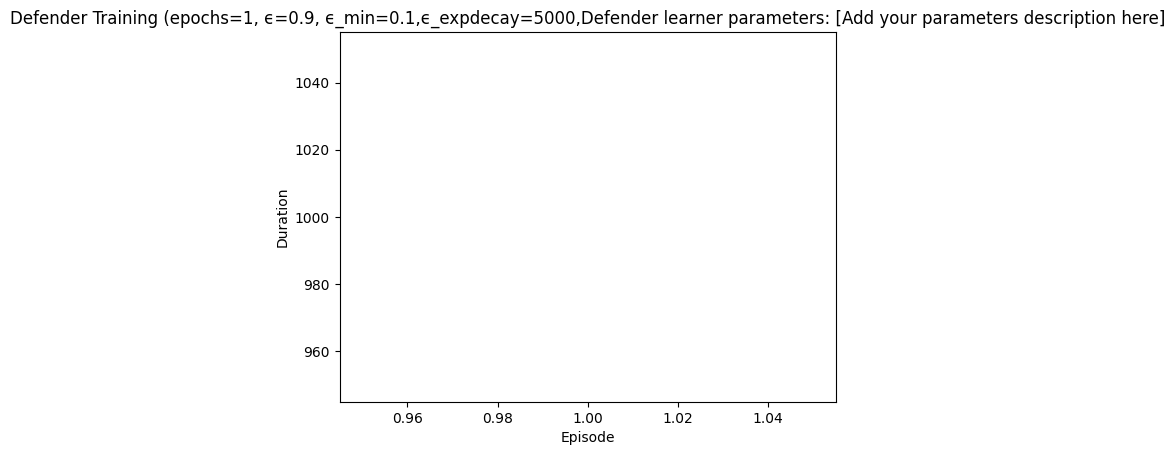

Rendering the current state of the environment
simulation ended


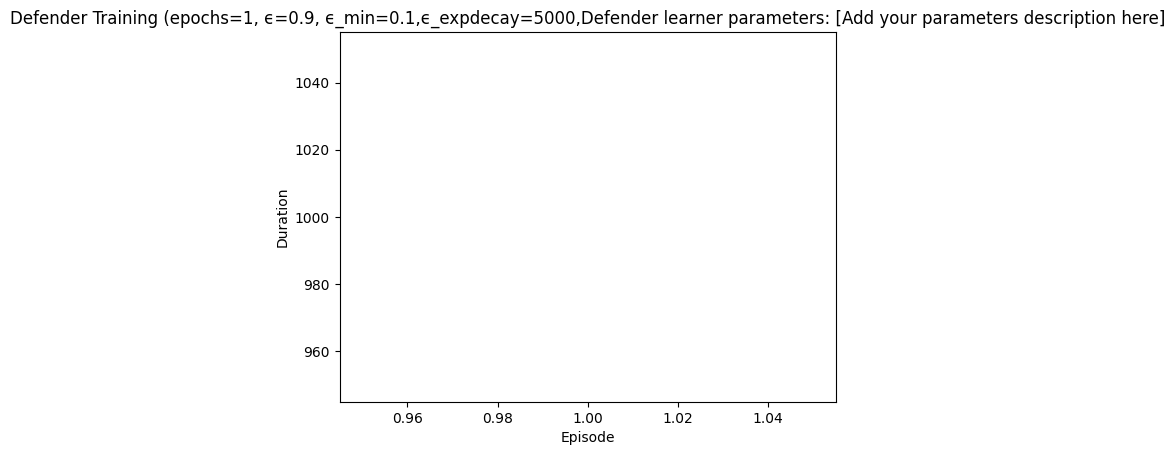

In [ ]:
random.seed(120394016)
#%matplotlib inline
trained_defender = epsilon_greedy_defender_training(
    cyberbattle_gym_env=defender,
    environment_properties=ep,
    learner=learner,
    episode_count=total_episodes,
    iteration_count=max_steps_per_episode,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=logging.INFO,
    render=True,
    plot_episodes_length=True,
    title="Defender Training"
)


actions resulting in successes sometimes are allow traffic and block traffic


most others were unnecessary and failed

defender reward is 0 because no attacker

needed to change cyberbattleenv and cyberbattlechain

# Q-matrix

In [ ]:
def random_argtop_percentile(array: np.ndarray, percentile: float):
    """Just like `argmax` but if there are multiple elements with the max
    return a random index to break ties instead of returning the first one."""
    top_percentile = np.percentile(array, percentile)
    indices = np.where(array >= top_percentile)[0]
    if len(indices) == 0:
        return random_argmax(array)
    elif indices.shape[0] > 1:
        max_index = int(np.random.choice(indices))
    else:
        max_index = int(indices)

    return top_percentile, max_index


In [ ]:
class QMatrix:
    """Q-Learning matrix for a given state and action space
        state_space  - Features defining the state space
        action_space - Features defining the action space
        qm           - Optional: initialization values for the Q matrix
    """
    # The Quality matrix
    qm: np.ndarray

    def __init__(self, name,
                 statespace: w.Feature,
                 actionspace: w.Feature,
                 qm: Optional[np.ndarray] = None):
        """Initialize the Q-matrix"""

        self.name = name
        self.statespace = statespace
        self.actionspace = actionspace
        self.statedim = statespace.flat_size()
        self.actiondim = actionspace.flat_size()
        self.qm = self.clear() if qm is None else qm

        # error calculated for the last update to the Q-matrix
        self.last_error = 0

    def shape(self):
        return (self.statedim, self.actiondim)

    def clear(self):
        """Re-initialize the Q-matrix to 0"""
        self.qm = np.zeros(shape=self.shape())
        # self.qm = np.random.rand(*self.shape()) / 100
        return self.qm

    def print(self):
        print(f"[{self.name}]\n"
              f"state: {self.statespace}\n"
              f"action: {self.actionspace}\n"
              f"shape = {self.shape()}")

    def update(self, current_state: int, action: int, next_state: int, reward, gamma, learning_rate):
        """Update the Q matrix after taking `action` in state 'current_State'
        and obtaining reward=R[current_state, action]"""

        maxq_atnext, max_index = random_argmax(self.qm[next_state, ])

        # bellman equation for Q-learning
        temporal_difference = reward + gamma * maxq_atnext - self.qm[current_state, action]
        self.qm[current_state, action] += learning_rate * temporal_difference

        # The loss is calculated using the squared difference between
        # target Q-Value and predicted Q-Value
        square_error = temporal_difference * temporal_difference
        self.last_error = square_error

        return self.qm[current_state, action]

    def exploit(self, features, percentile) -> Tuple[int, float]:
        """exploit: leverage the Q-matrix.
        Returns the expected Q value and the chosen action."""
        expected_q, action = random_argtop_percentile(self.qm[features, :], percentile)
        return int(action), float(expected_q)

# class DefenderQMatrix(QMatrix)

In [ ]:
import numpy as np
from typing import Tuple

class DefenderQMatrix(QMatrix):
    def __init__(self, statespace, actionspace, defender):
        super().__init__('Defender Q-Matrix', statespace, actionspace)
        self.defender = defender


    '''
    update the Q-matrix based on the temporal difference error. It calculates the temporal difference, updates the Q-value, and returns the updated Q-value.
    '''
    def update(self, current_state: int, action: int, next_state: int, reward, gamma, learning_rate):
        """Update the Q matrix for the defender agent"""
        maxq_atnext, max_index = random_argmax(self.qm[next_state, ])

        #customise the temporal difference calculation
        temporal_difference = reward + gamma * maxq_atnext - self.qm[current_state, action]
        self.qm[current_state, action] += learning_rate * temporal_difference

        #customise the error calculation as needed
        square_error = temporal_difference * temporal_difference
        self.last_error = square_error

        return self.qm[current_state, action]

    def exploit(self, wrapped_env, observation):
        test_state_index = 0
        test_action_index = 0

        if test_state_index < self.statedim and test_action_index < self.actiondim:
            q_value = self.qm[test_state_index, test_action_index]
            return test_action_index, q_value
        else:
            raise IndexError("Test state or action index out of bounds.")

    '''
    returns the maximum Q-value for a given state, handling terminal states by returning a default value.
    '''
    def get_max_q_value(self, state):
        """Return the maximum Q-value for a given state."""
        # Handle terminal state
        if state == -1:
            return 0

        if 0 <= state < self.qm.shape[0]:
            return np.max(self.qm[state, :])
        else:
            raise IndexError(f"State index out of bounds: {state}")

    '''
    returns the Q-value for a specific state-action pair, checking if the indices are within bounds.
    '''
    def get_q_value(self, state, action):
        """Return the Q-value for a specific state-action pair."""
        if state >= 0 and state < self.qm.shape[0] and action >= 0 and action < self.qm.shape[1]:
            return self.qm[state, action]
        else:
            raise IndexError("State or action index out of bounds.")

    '''
    allows for manually updating a specific state-action pair's Q-value.
    '''
    def update_q_value(self, state, action, new_q_value):
        """Update the Q-value for a specific state-action pair."""
        if state >= 0 and state < self.qm.shape[0] and action >= 0 and action < self.qm.shape[1]:
            self.qm[state, action] = new_q_value
        else:
            raise IndexError("State or action index out of bounds.")

In [ ]:
gym_env

<OrderEnforcing<CyberBattleChain<CyberBattleChain-v0>>>

In [ ]:
defender

In [ ]:
import numpy as np


class StateAugmentation:
    """Default agent state augmentation, consisting of the gym environment
    observation itself and nothing more."""

    def __init__(self, observation: cyberbattle_env.Observation):
        self.observation = observation

    def on_step(self, action: cyberbattle_env.Action, reward: float, done: bool, observation: cyberbattle_env.Observation):
        self.observation = observation

    def on_reset(self, observation: cyberbattle_env.Observation):
        self.observation = observation


class Feature(spaces.MultiDiscrete):
    """
    Feature consisting of multiple discrete dimensions.
    Parameters:
        nvec: is a vector defining the number of possible values
        for each discrete space.
    """

    def __init__(self, env_properties: ep, nvec):
        self.env_properties = env_properties
        super().__init__(nvec)

    def flat_size(self):
        return np.prod(self.nvec, dtype=int)

    def name(self):
        """Return the name of the feature"""
        p = len(type(Feature(self.env_properties, [])).__name__) + 1
        return type(self).__name__[p:]

    def get(self, a: StateAugmentation, node: Optional[int]) -> np.ndarray:
        """Compute the current value of a feature value at
        the current observation and specific node"""
        raise NotImplementedError

    def pretty_print(self, v):
        return v

class Feature_discovered_ports_sliding(Feature):
    def __init__(self, env_properties, sliding_window_size=10):
        self.env_properties = env_properties
        self.sliding_window_size = sliding_window_size

    def get(self, a: StateAugmentation, node=None):
        observation = a if isinstance(a, dict) else a.observation

        # Modify the feature extraction based on the actual observation structure
        if 'discovered_ports' in observation:
            discovered_ports = observation['discovered_ports']
            sliding_mean = np.mean(discovered_ports[-self.sliding_window_size:])
            return np.array([sliding_mean])

        return np.array([0])  # Default feature if data is not available

class Feature_discovered_nodeproperties_sliding(Feature):
    """Bitmask indicating node properties seen in last few cache entries"""
    window_size = 3

    def __init__(self, env_properties):
        super().__init__(env_properties, [2] * env_properties.property_count)

    def get(self, a: StateAugmentation, node=None) -> np.ndarray:
        observation = a if isinstance(a, dict) else a.observation

        if 'discovered_node_count' in observation and 'discovered_nodes_properties' in observation:
            n = observation['discovered_node_count']
            node_prop = np.array(observation['discovered_nodes_properties'])[:n]

            node_prop_window = node_prop[-self.window_size:, :]

            node_prop_window_remapped = np.int32(node_prop_window % 2)

            countby = np.sum(node_prop_window_remapped, axis=0)

            bitmask = (countby > 0) * 1
            return bitmask

        return np.zeros(self.env_properties.property_count, dtype=np.int32)


class Feature_discovered_notowned_node_count(Feature):
    """number of nodes discovered that are not owned yet (optionally clipped)"""

    def __init__(self, env_properties, clip: Optional[int]):
        self.clip = env_properties.maximum_node_count if clip is None else clip
        super().__init__(env_properties, [self.clip + 1])

    def get(self, a: StateAugmentation, node: Optional[int] = None) -> np.ndarray:
        observation = a if isinstance(a, dict) else a.observation

        if 'discovered_node_count' in observation and 'discovered_nodes_properties' in observation:
            discovered = observation['discovered_node_count']
            node_props = np.array(observation['discovered_nodes_properties'][:discovered])
            owned = np.count_nonzero(np.all(node_props != 2, axis=1))
            diff = discovered - owned
            return np.array([min(diff, self.clip)])

        return np.array([0])  # Replace with an appropriate default value


# Create instances of DefenderQMatrix

In [ ]:
# Create instances of DefenderQMatrix and DefenderEpsilonGreedyLearner
state_space_size = w.HashEncoding(ep, [
            # Feature_discovered_node_count(),
            # Feature_discovered_credential_count(),
            w.Feature_discovered_ports_sliding(ep),
            w.Feature_discovered_nodeproperties_sliding(ep),
            w.Feature_discovered_notowned_node_count(ep, 3)
        ], 5000)  # should not be too small, pick something big to avoid collision

action_space_size = w.RavelEncoding(ep, [
            w.Feature_active_node_properties(ep)])
q_matrix = DefenderQMatrix(state_space_size, action_space_size,defender)

epsilon = 0.9  #epsilon for epsilon-greedy strategy
gamma = 0.95  #discount factor
learning_rate = 0.1  #learning rate

# DefenderQLearner

In [ ]:
import numpy as np
from typing import Tuple, Optional
import random
import cyberbattle.agents.baseline.agent_wrapper as w
#environment_properties: w.EnvironmentBounds,

In [ ]:
class DefenderQLearner(EpsilonGreedyLearner):
    def __init__(self, env, defender, ep, q_matrix: DefenderQMatrix, epsilon, gamma, learning_rate):
        super().__init__(env, defender, epsilon)
        self.defender = defender
        self.q_matrix = q_matrix
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        #self.defender_actions = defender_actions
        self.SOME_THRESHOLD = 3

    def explore(self, wrapped_env) -> Tuple[str, Action, Optional[object]]:
        action = wrapped_env.sample_valid_action()
        action_style = "explore"
        action_metadata = None
        return action_style, action, action_metadata

    def convert_action_index_to_action(self, action_index, node_id, parameter):
        """
        Convert an action index to an action representation.

        Args:
            action_index (int): The index of the action to be converted.
            node_id (int): The ID of the node associated with the action.
            parameter (int): The parameter value for the action.

        Returns:
            dict: An action representation as a dictionary.
        """
        # Define a mapping from action indices to action types
        action_mapping = {
            0: 'Reimage Node',
            1: 'Block Traffic',
            2: 'Allow Traffic',
            3: 'Stop Service',
            4: 'Start Service'
        }

        #if the action index is valid
        if action_index not in action_mapping:
            raise ValueError("Invalid action index")

        #action dictionary
        action_type = action_mapping[action_index]
        action = {
            'action_type': action_type,
            'node_id': node_id,
            'parameter': parameter
        }

        return action

    def exploit(self, state,observation) -> Tuple[str, Action, Optional[object]]:
        #action_index = self.q_matrix.exploit_action(state)
        percentile = 50
        print("Observation:", observation)
        #define features based on the observation
        features = {
            'infected_nodes': observation['infected_nodes'],
            'firewall_status': observation['firewall_status'],
            'service_status': observation['service_status']
        }

        action_index, _ = self.q_matrix.exploit(features, percentile)

        node_id = self.extract_node_id_from_observation(observation)
        parameter = self.determine_parameter_based_on_state(observation)

        if node_id is not None:
            action = self.convert_action_index_to_action(action_index, node_id, parameter)
            action_style = "exploit"
            return action_style, action, None
        else:
            return "explore", None, None

    def extract_node_id_from_observation(self, observation):
        infected_nodes = observation.get('infected_nodes', [])
        for index, is_infected in enumerate(infected_nodes):
            if is_infected == 1:
                return index
        return None

    def determine_parameter_based_on_state(self, observation):
        infected_nodes = observation.get('infected_nodes', [])
        number_of_infected_nodes = sum(infected_nodes)
        parameter = 1 if number_of_infected_nodes > self.SOME_THRESHOLD else 0
        return parameter




    def update_q_matrix(self, state, action, reward, next_state):
        max_future_q = self.q_matrix.get_max_q_value(next_state)
        current_q = self.q_matrix.get_q_value(state, action)
        #calculate the new Q-value
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.gamma * max_future_q)
        #update the Q-matrix with the new Q-value
        self.q_matrix.update_q_value(state, action, new_q)

    def on_step(self, wrapped_env, action, reward, next_observation, done, info):
        observation = self.defender.get_observation()
        current_state = self.q_matrix.statespace.encode(observation)
        next_state = self.q_matrix.statespace.encode(observation) if not done else -1
        action_index = self.encode_action(action)
        self.update_q_matrix(current_state, action_index, reward, next_state)


    def end_of_iteration(self, current_iteration: int, total_iterations: int):
        pass

    def end_of_episode(self, i_episode=None, t=None):
        """
        Modified end_of_episode method with additional parameters.
        """
        pass


    def parameters_as_string(self):
        return "Defender learner parameters: []"

    def encode_state(self, observation):
        state_index = 0
        return state_index

    def encode_action(self, action_metadata):
        action_index = 0
        return action_index

    def new_episode(self):
        pass

    def all_parameters_as_string(self):
        return ''

    def loss_as_string(self):
        return ''

    def stateaction_as_string(self, action_metadata):
        return ''


# Create instance of DefenderQLearner

In [ ]:
statespace = w.HashEncoding(ep, [
            # Feature_discovered_node_count(),
            # Feature_discovered_credential_count(),
            Feature_discovered_ports_sliding(ep),
            Feature_discovered_nodeproperties_sliding(ep),
            Feature_discovered_notowned_node_count(ep, 3)
        ], 5000)  # should not be too small, pick something big to avoid collision

actionspace = w.RavelEncoding(ep, [
            w.Feature_active_node_properties(ep)])

q_matrix = DefenderQMatrix(statespace, actionspace,defender)
learner = DefenderQLearner(gym_env, defender, ep, q_matrix, epsilon, gamma, learning_rate)

# Run Q learning simulation

###### Defender Q-Learning Training
Learning with: episode_count=1,iteration_count=1000,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,Defender learner parameters: [Add your parameters description here]
  ## Episode: 1/1 'Defender Q-Learning Training' ϵ=0.9000, Defender learner parameters: [Add your parameters description here]


Episode 1|Iteration 29|reward:   25.0|last_reward_at:   28|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]), 'firewall_status': array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]), 'service_status': array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 1:
  Action Taken: {'action_type': 0, 'node_id': 5, 'parameter': 2}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '4_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]), 'firewall_status': array([0, 

Episode 1|Iteration 31|reward:   50.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]), 'service_status': array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]), 'service_status': array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 64|reward:  270.0|last_reward_at:   63|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]), 'service_status': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 32:
  Action Taken: {'action_type': 2, 'node_id': 7, 'parameter': 4}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '6_WindowsNode', 'port_name': 4}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

Episode 1|Iteration 64|reward:  270.0|last_reward_at:   64|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 'service_status': array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 65:
  Action Taken: {'action_type': 2, 'node_id': 13, 'parameter': 7}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '12_WindowsNode', 'port_name': 7}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 

Episode 1|Iteration 93|reward:  495.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Observation:: {'infected_nodes': array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]), 'service_status': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 66:
  Action Taken: {'action_type': 1, 'node_id': 0, 'parameter': 0}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': 'start', 'port_name': 0}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]), '

Episode 1|Iteration 94|reward:  480.0|last_reward_at:   91|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]), 'firewall_status': array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]), 'service_status': array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 94:
  Action Taken: {'action_type': 4, 'node_id': 1, 'parameter': 3}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 3, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]), 'firewall_status': array([1, 0, 0,

Episode 1|Iteration 125|reward:  440.0|last_reward_at:  115|Elapsed Time: 0:00:00||

  Observation:: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]), 'firewall_status': array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]), 'service_status': array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 95:
  Action Taken: {'action_type': 1, 'node_id': 7, 'parameter': 8}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '6_WindowsNode', 'port_name': 8}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]), 'firewall_status': array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,

Episode 1|Iteration 128|reward:  425.0|last_reward_at:  115|Elapsed Time: 0:00:00||

Observation: {'infected_nodes': array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]), 'firewall_status': array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]), 'service_status': array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]), 'firewall_status': array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]), 'service_status': array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 160|reward:  420.0|last_reward_at:  153|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]), 'service_status': array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 129:
  Action Taken: {'action_type': 4, 'node_id': 12, 'parameter': 2}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '11_LinuxNode', 'port_name': 2, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]), 'firewall_status': array([0, 1, 

Episode 1|Iteration 163|reward:  430.0|last_reward_at:  163|Elapsed Time: 0:00:01||


Iteration 162:
  Action Taken: {'action_type': 0, 'node_id': 13, 'parameter': 3}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '12_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]), 'service_status': array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]), 'firewall_status': array

Episode 1|Iteration 191|reward:  400.0|last_reward_at:  190|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]), 'service_status': array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 164:
  Action Taken: {'action_type': 4, 'node_id': 12, 'parameter': 2}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '11_LinuxNode', 'port_name': 2, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]), 'firewall_status': array([0, 1, 

Episode 1|Iteration 193|reward:  410.0|last_reward_at:  190|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]), 'service_status': array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 192:
  Action Taken: {'action_type': 0, 'node_id': 3, 'parameter': 6}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '2_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0

Episode 1|Iteration 222|reward:  355.0|last_reward_at:  220|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]), 'service_status': array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 194:
  Action Taken: {'action_type': 1, 'node_id': 10, 'parameter': 8}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '9_LinuxNode', 'port_name': 8}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,

Episode 1|Iteration 223|reward:  380.0|last_reward_at:  223|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]), 'firewall_status': array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]), 'service_status': array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 223:
  Action Taken: {'action_type': 2, 'node_id': 13, 'parameter': 5}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '12_WindowsNode', 'port_name': 5}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]), 'firewall_status': array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,

Episode 1|Iteration 254|reward:  465.0|last_reward_at:  253|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]), 'service_status': array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 224:
  Action Taken: {'action_type': 0, 'node_id': 5, 'parameter': 8}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '4_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([0

Episode 1|Iteration 255|reward:  490.0|last_reward_at:  253|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'firewall_status': array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]), 'service_status': array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 255:
  Action Taken: {'action_type': 1, 'node_id': 3, 'parameter': 8}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '2_WindowsNode', 'port_name': 8}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'firewall_status': array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0

Episode 1|Iteration 283|reward:  460.0|last_reward_at:  280|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]), 'firewall_status': array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]), 'service_status': array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 256:
  Action Taken: {'action_type': 0, 'node_id': 12, 'parameter': 1}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '11_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]), 'firewall_status': array([0

Episode 1|Iteration 284|reward:  445.0|last_reward_at:  280|Elapsed Time: 0:00:01||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]), 'service_status': array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 284:
  Action Taken: {'action_type': 4, 'node_id': 8, 'parameter': 5}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '7_LinuxNode', 'port_name': 5, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([1, 0, 1,

Episode 1|Iteration 312|reward:  420.0|last_reward_at:  311|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]), 'service_status': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 285:
  Action Taken: {'action_type': 1, 'node_id': 5, 'parameter': 6}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '4_WindowsNode', 'port_name': 6}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0

Episode 1|Iteration 315|reward:  415.0|last_reward_at:  314|Elapsed Time: 0:00:02||

  Observation:: {'infected_nodes': array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]), 'service_status': array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 313:
  Action Taken: {'action_type': 0, 'node_id': 9, 'parameter': 4}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '8_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]), 'firewall_status': array([0

Episode 1|Iteration 342|reward:  550.0|last_reward_at:  342|Elapsed Time: 0:00:02||

Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]), 'firewall_status': array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]), 'service_status': array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]), 'service_status': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 345|reward:  545.0|last_reward_at:  343|Elapsed Time: 0:00:02||


  Observation:: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]), 'service_status': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 344:
  Action Taken: {'action_type': 0, 'node_id': 6, 'parameter': 2}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '5_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]), 'firewall_status': array([1,

Episode 1|Iteration 373|reward:  745.0|last_reward_at:  373|Elapsed Time: 0:00:02||

  Action Result: {'status': 'error', 'reason': 'Unknown action type'}
  Reward: 0
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]), 'service_status': array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]), 'service_status': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 

Episode 1|Iteration 376|reward:  780.0|last_reward_at:  375|Elapsed Time: 0:00:02||

Iteration 374:
  Action Taken: {'action_type': 1, 'node_id': 8, 'parameter': 7}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '7_LinuxNode', 'port_name': 7}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]), 'firewall_status': array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]), 'service_status': array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 

Episode 1|Iteration 402|reward:  815.0|last_reward_at:  399|Elapsed Time: 0:00:02||


Iteration 377:
  Action Taken: {'action_type': 'Reimage Node', 'node_id': 1, 'parameter': 1}
  Action Result: {'status': 'error', 'reason': 'Unknown action type'}
  Reward: 0
  New Observation: {'infected_nodes': array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]), 'firewall_status': array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]), 'service_status': array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]), 'service_status': ar

Episode 1|Iteration 405|reward:  850.0|last_reward_at:  404|Elapsed Time: 0:00:02||


  Observation:: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]), 'service_status': array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 404:
  Action Taken: {'action_type': 1, 'node_id': 5, 'parameter': 9}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '4_WindowsNode', 'port_name': 9}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 

Episode 1|Iteration 430|reward:  990.0|last_reward_at:  429|Elapsed Time: 0:00:02||

Observation: {'infected_nodes': array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]), 'firewall_status': array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]), 'service_status': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]), 'service_status': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 435|reward: 1025.0|last_reward_at:  434|Elapsed Time: 0:00:02||

  Action Result: {'status': 'error', 'reason': 'Unknown action type'}
  Reward: 0
  New Observation: {'infected_nodes': array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]), 'service_status': array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), 'firewall_status': array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0]), 'service_status': array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 

Episode 1|Iteration 458|reward: 1125.0|last_reward_at:  458|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]), 'service_status': array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 436:
  Action Taken: {'action_type': 4, 'node_id': 7, 'parameter': 0}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '6_WindowsNode', 'port_name': 0, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 

Episode 1|Iteration 463|reward: 1145.0|last_reward_at:  463|Elapsed Time: 0:00:03||

Observation: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]), 'service_status': array([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]), 'firewall_status': array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'service_status': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 492|reward: 1085.0|last_reward_at:  488|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]), 'service_status': array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 465:
  Action Taken: {'action_type': 3, 'node_id': 12, 'parameter': 8}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '11_LinuxNode', 'port_name': 8, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 1

Episode 1|Iteration 493|reward: 1070.0|last_reward_at:  492|Elapsed Time: 0:00:03||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]), 'firewall_status': array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]), 'service_status': array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 493:
  Action Taken: {'action_type': 3, 'node_id': 3, 'parameter': 2}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 2, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]), 'firewall_status': array([1, 1, 0

Episode 1|Iteration 523|reward: 1170.0|last_reward_at:  523|Elapsed Time: 0:00:03||


  Observation:: {'infected_nodes': array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]), 'service_status': array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 496:
  Action Taken: {'action_type': 3, 'node_id': 3, 'parameter': 4}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 4, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]), 'firewall_status': array([0, 0, 

Episode 1|Iteration 529|reward: 1135.0|last_reward_at:  527|Elapsed Time: 0:00:03||


Iteration 524:
  Action Taken: {'action_type': 'Reimage Node', 'node_id': 0, 'parameter': 1}
  Action Result: {'status': 'error', 'reason': 'Unknown action type'}
  Reward: 0
  New Observation: {'infected_nodes': array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]), 'service_status': array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]), 'service_status': ar

Episode 1|Iteration 551|reward: 1320.0|last_reward_at:  549|Elapsed Time: 0:00:03||

Observation: {'infected_nodes': array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'firewall_status': array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]), 'service_status': array([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 557|reward: 1315.0|last_reward_at:  553|Elapsed Time: 0:00:03||


Iteration 553:
  Action Taken: {'action_type': 1, 'node_id': 11, 'parameter': 2}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '10_WindowsNode', 'port_name': 2}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]), 'firewall_status': array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]), 'service_status': array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]), 'firewall_status': array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0

Episode 1|Iteration 583|reward: 1375.0|last_reward_at:  582|Elapsed Time: 0:00:03||

Observation: {'infected_nodes': array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]), 'service_status': array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]), 'service_status': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 589|reward: 1315.0|last_reward_at:  582|Elapsed Time: 0:00:03||


Observation: {'infected_nodes': array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]), 'service_status': array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]), 'service_status': array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 

Episode 1|Iteration 616|reward: 1495.0|last_reward_at:  612|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]), 'firewall_status': array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]), 'service_status': array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 590:
  Action Taken: {'action_type': 2, 'node_id': 1, 'parameter': 0}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '13_LinuxNode', 'port_name': 0}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]), 'firewall_status': array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,

Episode 1|Iteration 621|reward: 1515.0|last_reward_at:  621|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]), 'firewall_status': array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 617:
  Action Taken: {'action_type': 0, 'node_id': 5, 'parameter': 5}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '4_WindowsNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]), 'firewall_status': array([1

Episode 1|Iteration 645|reward: 1510.0|last_reward_at:  639|Elapsed Time: 0:00:04||


Iteration 622:
  Action Taken: {'action_type': 2, 'node_id': 4, 'parameter': 7}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '3_LinuxNode', 'port_name': 7}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]), 'service_status': array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Observation: {'infected_nodes': array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1]

Episode 1|Iteration 648|reward: 1545.0|last_reward_at:  647|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0]), 'service_status': array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 646:
  Action Taken: {'action_type': 1, 'node_id': 1, 'parameter': 8}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '13_LinuxNode', 'port_name': 8}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,

Episode 1|Iteration 669|reward: 1595.0|last_reward_at:  669|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]), 'service_status': array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 649:
  Action Taken: {'action_type': 1, 'node_id': 6, 'parameter': 7}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '5_LinuxNode', 'port_name': 7}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]), 'firewall_status': array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 

Episode 1|Iteration 677|reward: 1545.0|last_reward_at:  675|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]), 'firewall_status': array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]), 'service_status': array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 673:
  Action Taken: {'action_type': 4, 'node_id': 1, 'parameter': 1}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 1, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]), 'firewall_status': array([0, 0, 0

Episode 1|Iteration 704|reward: 1645.0|last_reward_at:  703|Elapsed Time: 0:00:04||

  Observation:: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]), 'service_status': array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 678:
  Action Taken: {'action_type': 4, 'node_id': 3, 'parameter': 6}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]), 'firewall_status': array([0, 1, 

Episode 1|Iteration 709|reward: 1585.0|last_reward_at:  703|Elapsed Time: 0:00:04||

  New Observation: {'infected_nodes': array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]), 'service_status': array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Observation: {'infected_nodes': array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]), 'firewall_status': array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]), 'service_status': array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1

Episode 1|Iteration 734|reward: 1605.0|last_reward_at:  733|Elapsed Time: 0:00:04||

  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]), 'firewall_status': array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]), 'service_status': array([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]), 'firewall_status': array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]), 'service_status': array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': 

Episode 1|Iteration 741|reward: 1625.0|last_reward_at:  738|Elapsed Time: 0:00:04||


  Action Result: {'status': 'error', 'reason': 'Unknown action type'}
  Reward: 0
  New Observation: {'infected_nodes': array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]), 'firewall_status': array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]), 'firewall_status': array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]), 'service_status': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0,

Episode 1|Iteration 771|reward: 1650.0|last_reward_at:  771|Elapsed Time: 0:00:05||

  Observation:: {'infected_nodes': array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]), 'firewall_status': array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]), 'service_status': array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 742:
  Action Taken: {'action_type': 1, 'node_id': 0, 'parameter': 3}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': 'start', 'port_name': 3}
  Reward: 25
  New Observation: {'infected_nodes': array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]), 'firewall_status': array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]), '

Episode 1|Iteration 777|reward: 1680.0|last_reward_at:  777|Elapsed Time: 0:00:05||

  Observation:: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]), 'service_status': array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 773:
  Action Taken: {'action_type': 4, 'node_id': 12, 'parameter': 8}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '11_LinuxNode', 'port_name': 8, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]), 'firewall_status': array([0, 0, 

Episode 1|Iteration 816|reward: 2000.0|last_reward_at:  814|Elapsed Time: 0:00:05||


Observation: {'infected_nodes': array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]), 'service_status': array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]), 'firewall_status': array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]), 'service_status': array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 

Episode 1|Iteration 822|reward: 1965.0|last_reward_at:  822|Elapsed Time: 0:00:05||

Observation: {'infected_nodes': array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]), 'firewall_status': array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]), 'service_status': array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]), 'service_status': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 849|reward: 1990.0|last_reward_at:  847|Elapsed Time: 0:00:05||

  Action Taken: {'action_type': 1, 'node_id': 7, 'parameter': 2}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '6_WindowsNode', 'port_name': 2}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]), 'firewall_status': array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]), 'service_status': array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]), 'firewall_status': array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]), 'service

Episode 1|Iteration 852|reward: 2040.0|last_reward_at:  852|Elapsed Time: 0:00:05||

  Action Taken: {'action_type': 1, 'node_id': 12, 'parameter': 3}
  Action Result: {'action': 'block_traffic', 'status': 'success', 'node_id': '11_LinuxNode', 'port_name': 3}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]), 'firewall_status': array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]), 'service_status': array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]), 'service

Episode 1|Iteration 880|reward: 2100.0|last_reward_at:  878|Elapsed Time: 0:00:05||


Iteration 854:
  Action Taken: {'action_type': 4, 'node_id': 1, 'parameter': 7}
  Action Result: {'action': 'start_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 7, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]), 'firewall_status': array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]), 'service_status': array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 'firewall_status': array([1, 0, 

Episode 1|Iteration 885|reward: 2120.0|last_reward_at:  884|Elapsed Time: 0:00:05||


  Observation:: {'infected_nodes': array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]), 'service_status': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 882:
  Action Taken: {'action_type': 0, 'node_id': 10, 'parameter': 2}
  Action Result: {'action': 'reimage_node', 'status': 'failed', 'node_id': '9_LinuxNode', 'reason': 'Node not reimageable or not compromised'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]), 'firewall_status': array([0

Episode 1|Iteration 913|reward: 2070.0|last_reward_at:  906|Elapsed Time: 0:00:05||

  Observation:: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]), 'service_status': array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 886:
  Action Taken: {'action_type': 2, 'node_id': 11, 'parameter': 4}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '10_WindowsNode', 'port_name': 4}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,

Episode 1|Iteration 915|reward: 2080.0|last_reward_at:  915|Elapsed Time: 0:00:06||

  Observation:: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), 'service_status': array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 914:
  Action Taken: {'action_type': 3, 'node_id': 1, 'parameter': 6}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '13_LinuxNode', 'port_name': 6, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]), 'firewall_status': array([0, 1, 0,

Episode 1|Iteration 944|reward: 2025.0|last_reward_at:  942|Elapsed Time: 0:00:06||


  Observation:: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]), 'service_status': array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 917:
  Action Taken: {'action_type': 3, 'node_id': 3, 'parameter': 4}
  Action Result: {'action': 'stop_service', 'status': 'failed', 'node_id': '2_WindowsNode', 'port_name': 4, 'reason': 'Service not found'}
  Reward: -15
  New Observation: {'infected_nodes': array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]), 'firewall_status': array([1, 1, 

Episode 1|Iteration 948|reward: 1995.0|last_reward_at:  942|Elapsed Time: 0:00:06||

Observation: {'infected_nodes': array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]), 'firewall_status': array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]), 'service_status': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]), 'firewall_status': array([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]), 'service_status': array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 977|reward: 1995.0|last_reward_at:  976|Elapsed Time: 0:00:06||

Observation: {'infected_nodes': array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]), 'firewall_status': array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]), 'service_status': array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
  Observation:: {'infected_nodes': array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]), 'service_status': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1

Episode 1|Iteration 979|reward: 2045.0|last_reward_at:  979|Elapsed Time: 0:00:06||

  Observation:: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]), 'service_status': array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Iteration 978:
  Action Taken: {'action_type': 2, 'node_id': 9, 'parameter': 3}
  Action Result: {'action': 'allow_traffic', 'status': 'success', 'node_id': '8_WindowsNode', 'port_name': 3}
  Reward: 25
  New Observation: {'infected_nodes': array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]), 'firewall_status': array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1

Episode 1|Iteration 1000|reward: 2000.0|last_reward_at:  994|Elapsed Time: 0:00:06||



  New Observation: {'infected_nodes': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]), 'service_status': array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Allow Traffic': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Stop Service': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Start Service': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}}
Observation: {'infected_nodes': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]), 'firewall_status': array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]), 'service_status': array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]), 'action_mask': {'Reimage Node': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), 'Block Traffic': array([1, 1, 1, 

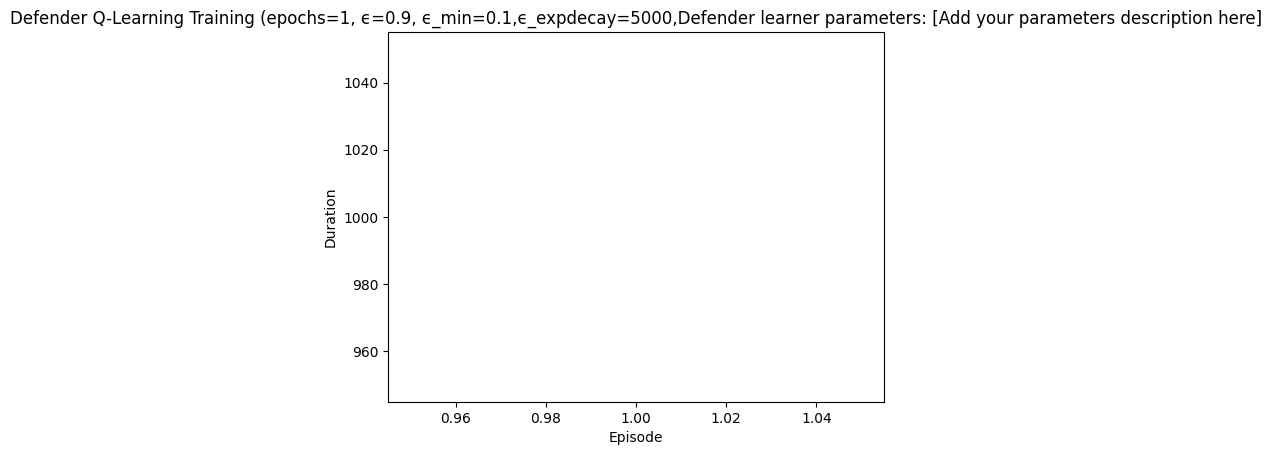

Rendering the current state of the environment
simulation ended


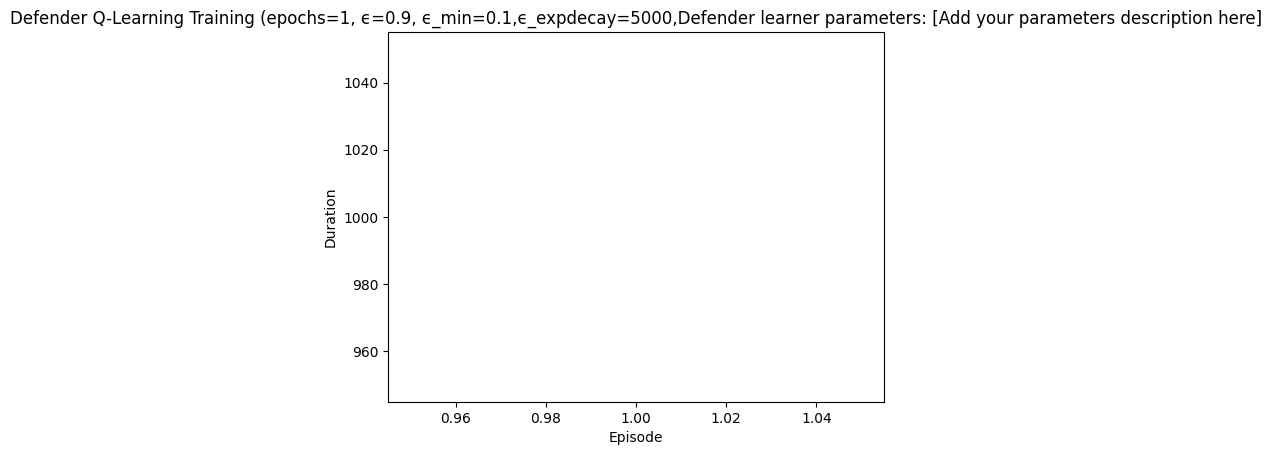

In [ ]:
random.seed(120394016)
#%matplotlib inline
trained_defender = epsilon_greedy_defender_training(
    cyberbattle_gym_env=defender,
    environment_properties=ep,
    learner=learner,
    episode_count=total_episodes,
    iteration_count=max_steps_per_episode,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=logging.INFO,
    render=True,
    plot_episodes_length=True,
    title="Defender Q-Learning Training"
)


edited the feature class in in file

In Deep Q-Learning, the Q-values for each action given a state are estimated using a neural network, rather than being stored and updated in a table.